In [ ]:
import cv2
import os
import glob


dataset_path = r"C:\Users\chkar\Documents\ML datasets\archive4\FaceForensics++_C23"  # Use raw string format

video_folders = [
    f"{dataset_path}\\DeepFakeDetection",
    f"{dataset_path}\\Deepfakes",
    f"{dataset_path}\\Face2Face",
    f"{dataset_path}\\FaceShifter",
    f"{dataset_path}\\FaceSwap",
    f"{dataset_path}\\NeuralTextures"
]
real_folder = f"{dataset_path}\\original"

output_fake = r"C:\Users\chkar\Documents\ML datasets\processed_data\fake"
output_real = r"C:\Users\chkar\Documents\ML datasets\processed_data\real"

# Create directories for extracted frames
import os
os.makedirs(output_fake, exist_ok=True)
os.makedirs(output_real, exist_ok=True)

# Function to extract frames
def extract_frames(video_path, output_folder, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(total_frames // num_frames, 1)  # Extract evenly spaced frames
    
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frame_name = os.path.join(output_folder, f"{os.path.basename(video_path)}_frame{frame_count}.jpg")
            cv2.imwrite(frame_name, frame)
        frame_count += 1
    cap.release()

# Extract frames from Fake Videos
for folder in video_folders:
    for video_path in glob.glob(f"{folder}\\*.mp4"):
        extract_frames(video_path, output_fake)

# Extract frames from Real Videos
for video_path in glob.glob(f"{real_folder}\\*.mp4"):
    extract_frames(video_path, output_real)

print("Frame extraction complete!")


In [ ]:
import cv2
import os
import glob

real_folder = r"C:\Users\chkar\Documents\ML datasets\archive4\FaceForensics++_C23\original"
output_real = r"C:\Users\chkar\Documents\ML datasets\processed_data\real"

# Create directory for extracted frames
os.makedirs(output_real, exist_ok=True)

def extract_frames(video_path, output_folder, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(total_frames // num_frames, 1)  # Extract evenly spaced frames
    
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frame_name = os.path.join(output_folder, f"{os.path.basename(video_path)}_frame{frame_count}.jpg")
            cv2.imwrite(frame_name, frame)
            print(f"Saved: {frame_name}")  # ✅ Debugging
        frame_count += 1
    cap.release()

# Extract frames from Real Videos
print(f"Processing real videos in: {real_folder}")  
for video_path in glob.glob(f"{real_folder}\\*.mp4"):
    print(f"Extracting from: {video_path}")  # ✅ Debugging
    extract_frames(video_path, output_real)

print("✅ Real frame extraction complete!")


In [ ]:
import cv2
import os
import glob

input_real = r"C:\Users\chkar\Documents\ML datasets\processed_data\real"
input_fake = r"C:\Users\chkar\Documents\ML datasets\processed_data\fake"
output_real = r"C:\Users\chkar\Documents\ML datasets\preprocessed_data\real"
output_fake = r"C:\Users\chkar\Documents\ML datasets\preprocessed_data\fake"

# Create output directories
os.makedirs(output_real, exist_ok=True)
os.makedirs(output_fake, exist_ok=True)

# Function to preprocess images
def preprocess_images(input_folder, output_folder):
    for img_path in glob.glob(input_folder + "/*.jpg"):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (256, 256))  # Resize to 256x256
        img = img / 255.0  # Normalize pixel values
        output_path = os.path.join(output_folder, os.path.basename(img_path))
        cv2.imwrite(output_path, img * 255)  # Save after rescaling

# Preprocess images
preprocess_images(input_real, output_real)
preprocess_images(input_fake, output_fake)

print("✅ Preprocessing complete!")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define parameters
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
data_dir = r"C:\Users\chkar\Documents\ML datasets\preprocessed_data"  # Update if needed

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2  # 80% training, 20% validation
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"
)

# Load validation data
val_generator = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)

print("✅ Data Generators Ready!")


In [ ]:
import os
import random
import shutil

fake_folder = r"C:\Users\chkar\Documents\ML datasets\processed_data\fake"
fake_images = os.listdir(fake_folder)

# Reduce fake images to 10k (random selection)
selected_fakes = random.sample(fake_images, 10000)

# Move selected images to a new folder
balanced_fake_folder = r"C:\Users\chkar\Documents\ML datasets\balanced_data\fake"
os.makedirs(balanced_fake_folder, exist_ok=True)

for img in selected_fakes:
    shutil.move(os.path.join(fake_folder, img), os.path.join(balanced_fake_folder, img))

print("✅ Fake dataset balanced to 10k images!")


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load XceptionNet (without top layers)
base_model = Xception(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)  # Binary classification (Real vs. Fake)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

print("✅ Model Ready for Training!")


In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

model_path = "deepfake_detector.h5"

try:
    model = load_model(model_path)
    print("✅ Model loaded successfully! Ready to use.")
except Exception as e:
    print("❌ Error loading model:", str(e))


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.fit(train_generator, epochs=5, validation_data=val_generator)


In [ ]:
model.save("deepfake_detector.h5")
print("✅ Model saved as deepfake_detector.h5")

In [ ]:
import os

real_folder = "C:/Users/chkar/Documents/ML datasets/preprocessed_data/real"
fake_folder = "C:/Users/chkar/Documents/ML datasets/preprocessed_data/fake"

num_real = len(os.listdir(real_folder))
num_fake = len(os.listdir(fake_folder))

print(f"✅ Total Real Images: {num_real}")
print(f"✅ Total Fake Images: {num_fake}")


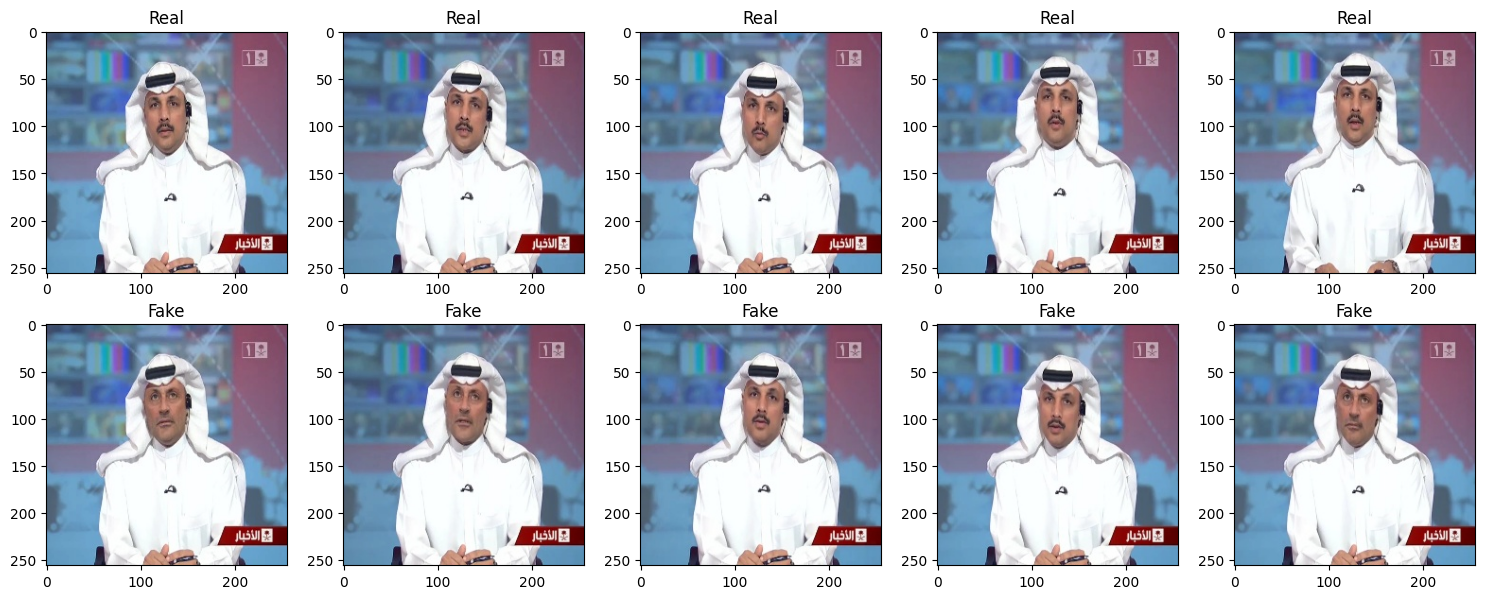

In [26]:
import cv2
import matplotlib.pyplot as plt

# Select a few sample images
real_images = os.listdir(real_folder)[:5]
fake_images = os.listdir(fake_folder)[:5]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    # Load images
    img_real = cv2.imread(os.path.join(real_folder, real_images[i]))
    img_fake = cv2.imread(os.path.join(fake_folder, fake_images[i]))

    # Convert BGR to RGB (for correct display)
    img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
    img_fake = cv2.cvtColor(img_fake, cv2.COLOR_BGR2RGB)

    # Display images
    axes[0, i].imshow(img_real)
    axes[0, i].set_title("Real")

    axes[1, i].imshow(img_fake)
    axes[1, i].set_title("Fake")

plt.tight_layout()
plt.show()


In [27]:
import numpy as np

def image_statistics(folder, num_samples=10):
    brightness, contrast = [], []
    
    for img_name in os.listdir(folder)[:num_samples]:
        img = cv2.imread(os.path.join(folder, img_name), cv2.IMREAD_GRAYSCALE)
        mean, std = np.mean(img), np.std(img)  # Mean = brightness, Std = contrast
        brightness.append(mean)
        contrast.append(std)

    return np.mean(brightness), np.mean(contrast)

# Compute for both classes
real_brightness, real_contrast = image_statistics(real_folder)
fake_brightness, fake_contrast = image_statistics(fake_folder)

print(f"✅ Real Images - Brightness: {real_brightness:.2f}, Contrast: {real_contrast:.2f}")
print(f"✅ Fake Images - Brightness: {fake_brightness:.2f}, Contrast: {fake_contrast:.2f}")


✅ Real Images - Brightness: 159.16, Contrast: 63.07
✅ Fake Images - Brightness: 158.41, Contrast: 63.04


In [28]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the trained model
model = load_model("deepfake_detector.h5")


In [29]:
def get_gradcam_heatmap(model, img_array, layer_name="conv2d"):  
    """
    Generate a Grad-CAM heatmap for a given image.
    
    model: Trained Keras model
    img_array: Preprocessed input image
    layer_name: Name of the convolutional layer to use for Grad-CAM
    """
    # Create a model that maps input image to activations and output predictions
    grad_model = tf.keras.models.Model(
        inputs=model.input, 
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])  # Get predicted class
        loss = predictions[:, predicted_class]  # Compute loss for that class

    grads = tape.gradient(loss, conv_outputs)  # Compute gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling

    # Multiply each channel by corresponding gradient importance
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize and resize
    cam = tf.maximum(cam, 0)
    cam = tf.squeeze(cam).numpy()
    cam = cv2.resize(cam, (img_array.shape[1], img_array.shape[2]))
    cam = (cam - cam.min()) / (cam.max() - cam.min()) * 255
    return np.uint8(cam)


1/1 [==============================] - 2s 2s/step


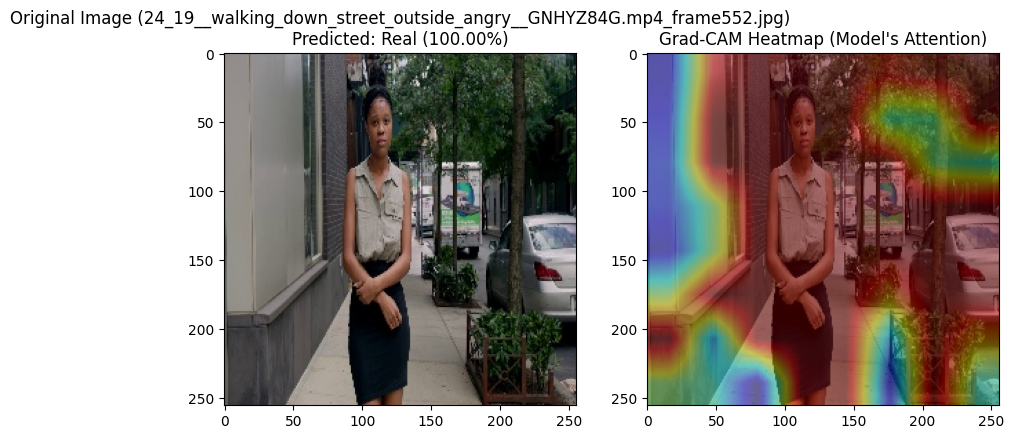

In [38]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import tensorflow as tf

# Load trained model
model = load_model("deepfake_detector.h5")

# Get last convolutional layer dynamically
def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

last_conv_layer_name = get_last_conv_layer(model)

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    return img_array

def get_gradcam_heatmap(model, image_array, target_class):
    """ Generates a Grad-CAM heatmap for the given image and class. """
    grad_model = tf.keras.models.Model(
        [model.input], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_array)
        loss = predictions[:, target_class]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0].numpy()  # Convert to NumPy array
    heatmap = np.zeros(dtype=np.float32, shape=conv_outputs.shape[:-1])

    for i in range(pooled_grads.shape[-1]):
        heatmap += pooled_grads[i].numpy() * conv_outputs[:, :, i]

    heatmap = np.maximum(heatmap, 0)  # ReLU operation
    heatmap = cv2.resize(heatmap, (256, 256))  # Resize to match input dimensions
    
    # Ensure heatmap is a NumPy array before applying min/max
    heatmap = np.array(heatmap)

    if heatmap.max() > heatmap.min():
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # Normalize
    else:
        heatmap = np.zeros_like(heatmap)  # If all values are the same, set to zeros

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert to RGB

    return heatmap

def apply_gradcam_random(folder_path, model):
    """ Selects a random image from folder, predicts if it's fake or real, and applies Grad-CAM. """
    
    images = [f for f in os.listdir(folder_path) if f.endswith((".jpg", ".png"))]
    
    if not images:
        print("❌ No images found in the folder!")
        return
    
    # Select a random image
    random_image = random.choice(images)
    image_path = os.path.join(folder_path, random_image)

    # Preprocess image and run model prediction
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    
    class_labels = ["Real", "Fake"]
    confidence = tf.nn.softmax(predictions[0]).numpy()
    predicted_label = class_labels[np.argmax(confidence)]
    
    # Generate Grad-CAM heatmap
    heatmap = get_gradcam_heatmap(model, img_array, target_class=np.argmax(confidence))

    # Overlay on original image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))
    overlayed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Original Image ({random_image})\nPredicted: {predicted_label} ({confidence[np.argmax(confidence)]:.2%})")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM Heatmap (Model's Attention)")

    plt.show()

# Example usage: Change the folder path to either real or fake images
apply_gradcam_random(r"C:\Users\chkar\Documents\ML datasets\preprocessed_data\fake", model)
